In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import cv2
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_tuner
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from kerastuner.tuners import RandomSearch

C:\Users\mithu\AppData\Local\Temp\ipykernel_11856\1476906118.py:15: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [2]:
main_dir = "S:/COLLEGE/INTERN/PRODIGY-Machine Learning"
train_dir = "S:/COLLEGE/INTERN/PRODIGY-Machine Learning/train"
path = os.path.join(main_dir,train_dir)

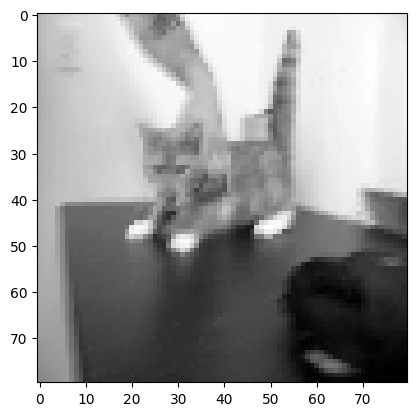

In [3]:
for p in os.listdir(path):
    category = p.split(".")[0]
    img_array = cv2.imread(os.path.join(path,p),cv2.IMREAD_GRAYSCALE)
    new_img_array = cv2.resize(img_array, dsize=(80, 80))
    plt.imshow(new_img_array,cmap="gray")
    break

In [4]:
X = []
y = []
convert = lambda category : int(category == 'dog')
def create_test_data(path):
    for p in os.listdir(path):
        category = p.split(".")[0]
        category = convert(category)
        img_array = cv2.imread(os.path.join(path,p),cv2.IMREAD_GRAYSCALE)
        new_img_array = cv2.resize(img_array, dsize=(80, 80))
        X.append(new_img_array)
        y.append(category)

In [5]:
create_test_data(path)
X = np.array(X).reshape(-1, 80,80,1)
y = np.array(y)
X = X/255.0

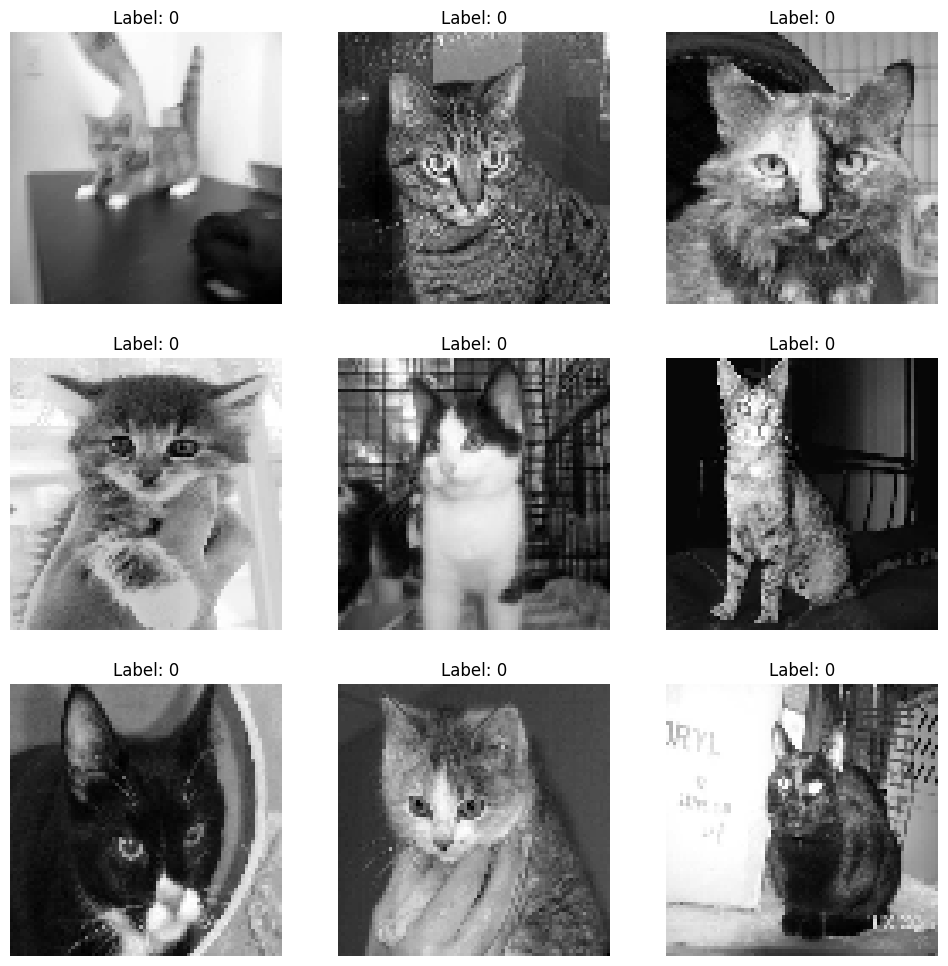

In [6]:
plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X[i].reshape(80, 80), cmap='gray')
    plt.title(f"Label: {y[i]}")
    plt.axis('off')
plt.show()

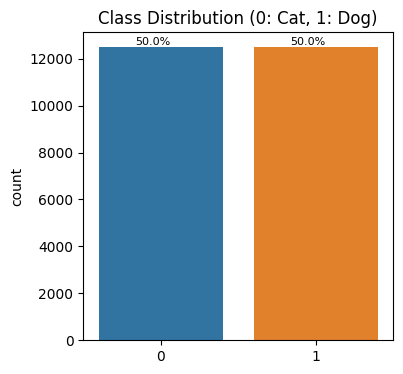

In [7]:
# Visualize class distribution with percentage values on top of the bars
plt.figure(figsize=(4, 4))
ax = sns.countplot(x=y)
plt.title('Class Distribution (0: Cat, 1: Dog)')

# Add percentage values on top of the bars
total = len(y)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    d = p.get_x() + p.get_width() / 2 - 0.05
    z = p.get_height() + 0.1
    ax.text(d, z, percentage, ha='center', va='bottom', fontsize=8, color='black')

plt.show()

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:
# Define the Deep Learning Model
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3), input_shape=(80, 80, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten and connect Dense layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# Output layer with a single neuron and sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

In [10]:
# Compile the model with optimizer and loss function
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [11]:
# Data augmentation
datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

# Create augmented data generators
train_generator = datagen.flow(X_train, y_train, batch_size=32)
val_generator = datagen.flow(X_val, y_val, batch_size=32)

In [12]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [13]:
# Train the model with augmented data and early stopping
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

Epoch 1/5
625/625 [==============================] - 101s 156ms/step - loss: 0.6589 - accuracy: 0.6009 - val_loss: 0.5990 - val_accuracy: 0.6826
Epoch 2/5
625/625 [==============================] - 95s 152ms/step - loss: 0.5823 - accuracy: 0.6985 - val_loss: 0.5458 - val_accuracy: 0.7328
Epoch 3/5
625/625 [==============================] - 95s 151ms/step - loss: 0.5355 - accuracy: 0.7415 - val_loss: 0.5262 - val_accuracy: 0.7404
Epoch 4/5
625/625 [==============================] - 94s 151ms/step - loss: 0.5060 - accuracy: 0.7597 - val_loss: 0.4910 - val_accuracy: 0.7606
Epoch 5/5
625/625 [==============================] - 93s 149ms/step - loss: 0.4868 - accuracy: 0.7704 - val_loss: 0.4894 - val_accuracy: 0.7610


In [14]:
# Evaluate the model performance on the validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

157/157 [==============================] - 6s 38ms/step - loss: 0.5080 - accuracy: 0.7482
Validation Loss: 0.5080251097679138, Validation Accuracy: 0.748199999332428


In [15]:
# Evaluate the model performance on the training data
model_loss, model_accuracy = model.evaluate(X, y)
print(f"Train Loss: {model_loss}, Train Accuracy: {model_accuracy}")

782/782 [==============================] - 30s 38ms/step - loss: 0.4741 - accuracy: 0.7686
Train Loss: 0.47411873936653137, Train Accuracy: 0.7686399817466736


In [16]:
from tensorflow.keras.preprocessing.image import load_img
import numpy as np

def preprocess(X):
      if isinstance(X, np.ndarray):
        # Already a NumPy array, just normalize
        X = X/255.0
        return X
      else:
        # Convert PIL image to NumPy array
        X = np.array(X)
        # Assuming RGB image, convert to grayscale 
        X = X[:, :, 0]
        # Reshape and normalize
        X = np.array(X).reshape(-1,80, 80, 1)
        X = X/255.0
        return X

img = load_img('S:/COLLEGE/INTERN/PRODIGY-Machine Learning/image.jpg', target_size=(80, 80))
U = preprocess(img)

preds = model.predict(U)

1/1 [==============================] - 0s 421ms/step


In [17]:
preds

array([[0.95289177]], dtype=float32)

Text(0.5, 1.0, 'Accuracy Curves')

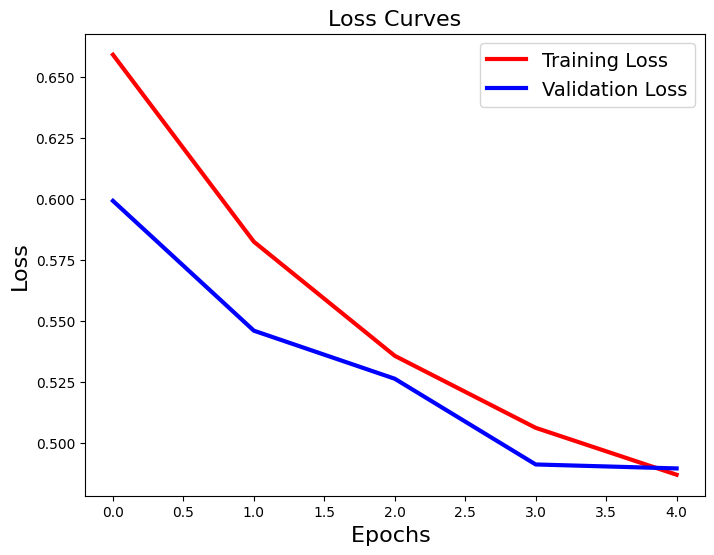

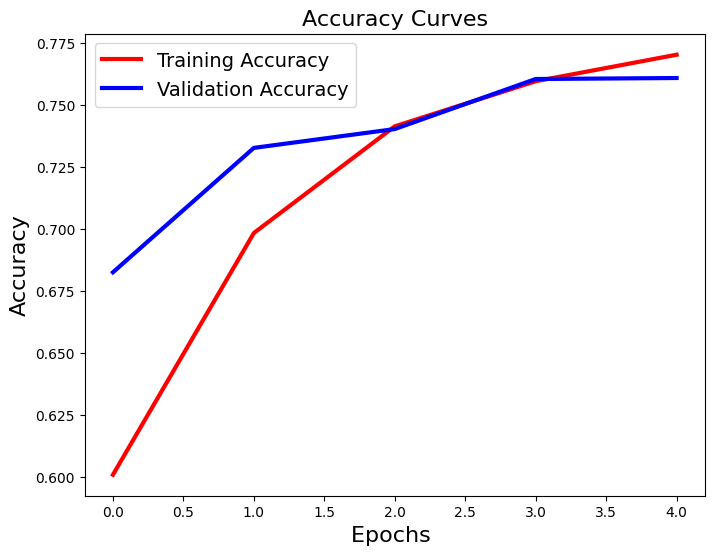

In [18]:
# Plot loss history
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training Loss', 'Validation Loss'],fontsize=14)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)


# Plot accuracy history
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=14)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [19]:
def build_model(hp):
    model = Sequential()
    model.add(Conv2D(hp.Int('conv1_units', min_value=128, max_value=256, step=64), (3, 3), input_shape=(80, 80, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(hp.Int('conv2_units', min_value=128, max_value=256, step=64), (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(hp.Int('dense1_units', min_value=128, max_value=256, step=64), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(hp.Int('dense2_units', min_value=128, max_value=256, step=64), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(hp.Choice('learning_rate', values=[1e-3, 1e-4])), # More rates can be added here
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [20]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=1,  # Adjust the number of trials as needed
    directory='keras_tuner_dir',
    project_name='cats_vs_dogs'
)

tuner.search(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

Trial 2 Complete [00h 43m 18s]
val_accuracy: 0.6826000213623047

Best val_accuracy So Far: 0.7031999826431274
Total elapsed time: 01h 39m 28s


In [21]:
tuner.results_summary()


Results summary
Results in keras_tuner_dir\cats_vs_dogs
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 00 summary
Hyperparameters:
conv1_units: 192
conv2_units: 128
dense1_units: 128
dense2_units: 256
learning_rate: 0.001
Score: 0.7031999826431274

Trial 01 summary
Hyperparameters:
conv1_units: 128
conv2_units: 256
dense1_units: 128
dense2_units: 128
learning_rate: 0.001
Score: 0.6826000213623047


In [22]:
# Get the best model from the search
best_model = tuner.get_best_models(num_models=1)[0]

In [23]:
# Evaluate the model performance on the validation set
val_loss, val_accuracy = best_model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

157/157 [==============================] - 27s 169ms/step - loss: 0.5411 - accuracy: 0.7304
Validation Loss: 0.5411229133605957, Validation Accuracy: 0.730400025844574


In [24]:
# Evaluate the model performance on the training data
model_loss, model_accuracy = best_model.evaluate(X, y)
print(f"Train Loss: {model_loss}, Train Accuracy: {model_accuracy}")

782/782 [==============================] - 129s 165ms/step - loss: 0.5251 - accuracy: 0.7404
Train Loss: 0.5251076817512512, Train Accuracy: 0.7404000163078308


In [25]:
history = best_model.fit(
    train_generator,
    epochs=1,  # Adjust the number of additional epochs as needed
    validation_data=val_generator,
    callbacks=[EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)]
)


625/625 [==============================] - 404s 644ms/step - loss: 0.5485 - accuracy: 0.7268 - val_loss: 0.5344 - val_accuracy: 0.7346


In [26]:
# Evaluate the model performance on the validation set
val_loss, val_accuracy = best_model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

157/157 [==============================] - 27s 174ms/step - loss: 0.5125 - accuracy: 0.7512
Validation Loss: 0.5124706029891968, Validation Accuracy: 0.7512000203132629


In [27]:
# Evaluate the model performance on the training data
model_loss, model_accuracy = best_model.evaluate(X, y)
print(f"Train Loss: {model_loss}, Train Accuracy: {model_accuracy}")

782/782 [==============================] - 140s 178ms/step - loss: 0.4940 - accuracy: 0.7630
Train Loss: 0.49395257234573364, Train Accuracy: 0.7630400061607361


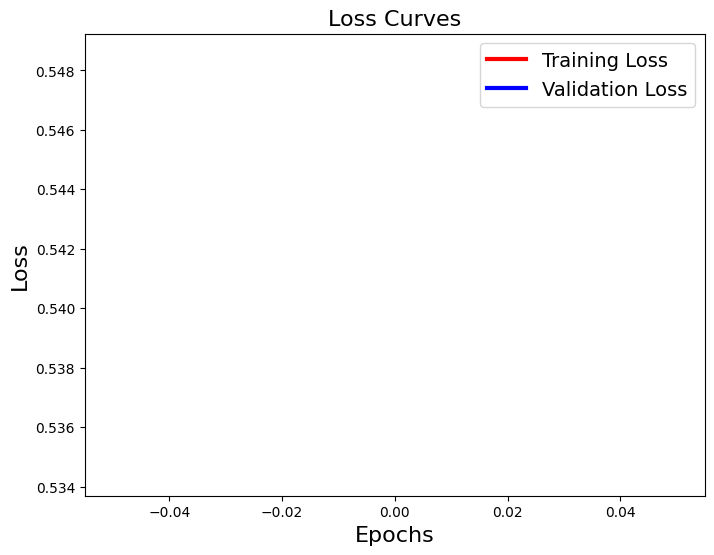

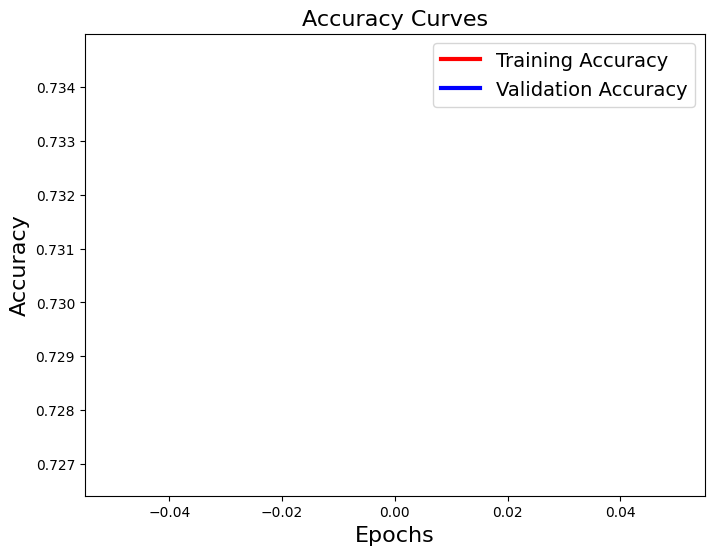

In [28]:
# Plot loss history
plt.figure(figsize=[8, 6])
plt.plot(history.history['loss'], 'r', linewidth=3.0)
plt.plot(history.history['val_loss'], 'b', linewidth=3.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Loss Curves', fontsize=16)
plt.show()

# Plot accuracy history
plt.figure(figsize=[8, 6])
plt.plot(history.history['accuracy'], 'r', linewidth=3.0)
plt.plot(history.history['val_accuracy'], 'b', linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.title('Accuracy Curves', fontsize=16)
plt.show()

In [29]:
# Save the model for further use
best_model.save('dog_cat_classifier.h5')

converter = tf.lite.TFLiteConverter.from_keras_model(best_model)

tflite_model = converter.convert()


with open('dog_cat_classifier.tflite', 'wb') as f_out:
    f_out.write(tflite_model)

C:\Users\mithu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: C:\Users\mithu\AppData\Local\Temp\tmp6wsalykn\assets


INFO:tensorflow:Assets written to: C:\Users\mithu\AppData\Local\Temp\tmp6wsalykn\assets


In [30]:
# Apply the model to predict on test data
test_dir = "S:/COLLEGE/INTERN/PRODIGY-Machine Learning/test"
test_path = os.path.join(main_dir,test_dir)
test_data = []
for p in os.listdir(test_path):
    img_array = cv2.imread(os.path.join(test_path,p),cv2.IMREAD_GRAYSCALE)
    new_img_array = cv2.resize(img_array, dsize=(80, 80))
    test_data.append(new_img_array)

test_data = np.array(test_data).reshape(-1, 80, 80, 1)
test_data = test_data/255.0

predictions = model.predict(test_data)

391/391 [==============================] - 12s 30ms/step


In [31]:
# Assuming predictions is a 2D array with values between 0 and 1
predictions = model.predict(test_data)

# Convert the predictions to labels (0 or 1)
binary_predictions = (predictions > 0.5).astype(int)

# Get the filenames from the test directory
test_filenames = os.listdir(test_path)

# Extract the IDs from the filenames
ids = [int(filename.split('.')[0]) for filename in test_filenames]

# Create a DataFrame with "id" and "label" columns
submission_df = pd.DataFrame({'id': ids, 'label': binary_predictions.flatten()})

# Save the DataFrame to a CSV file
submission_df.to_csv('submission.csv', index=False)

# Provide a link to download the CSV file
from IPython.display import FileLink

# Display a clickable link for downloading
FileLink('submission.csv')

391/391 [==============================] - 11s 29ms/step


C:\Users\mithu\submission.csv

In [32]:
print(submission_df)

          id  label
0          1      1
1         10      1
2        100      1
3       1000      1
4      10000      1
...      ...    ...
12495   9995      0
12496   9996      1
12497   9997      1
12498   9998      0
12499   9999      1

[12500 rows x 2 columns]
